<a href="https://colab.research.google.com/github/AkiraNom/data-analysis-notebook/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch data from the SQL database using sqlite3

In [3]:
# import sqlite3

# # connect to the sql database
# con = sqlite3.connect('database.sqlite')

# cur = con.cursor()

# try:
#   cur.execute("SELECT * FROM Reviews LIMIT 10")

#   print('Connected to the database successfully')

#   # fatch the data in a list
#   data_list = cur.fetchall()

#   # get column names
#   names = list(map(lambda x: x[0], cur.description))

#   # create a dataframe
#   # display(pd.DataFrame(data_list, columns=names).head())


# except sqlite3.OperationalError:
#     print('No such tables in the databse')


# # data query using pandas
# df_raw = pd.read_sql_query("SELECT * FROM Reviews", con)

# # check if the data is stored in the dataframe
# display(df_raw.head())

# # close the connection
# con.close()

In [4]:
# read the data from csv
df_raw = pd.read_csv('Reviews.csv')

In [5]:
print(df_raw.shape)
print(df_raw.info())

(568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


In [6]:
# Nan count in each column
df_raw.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
# check unique values in each column
df_raw.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

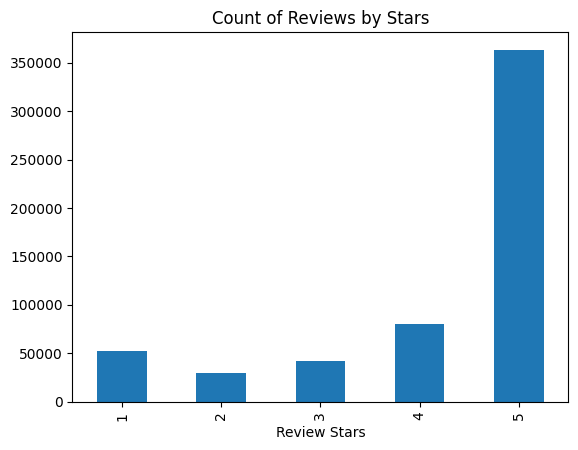

In [8]:
ax = df_raw['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars')
ax.set_xlabel('Review Stars')
plt.show()

In [9]:
# reduce computation time, feed only 1000 rows
n = 1000
df = df_raw.head(n).copy()

# Method 1: VANDER Sentiment Scoring

Natural Language Toolkit (NLTK) is a leading platform for building Python programs to work with human language data.

<br>

>Valence Aware Dictionary and sEntiment Reasoner (VADER) is a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.  

Github repository for [VANDER-Sentiment-Analysis](https://github.com/cjhutto/vaderSentiment)  

<br>

Using 'SentimentIntensityAnalyzer' to compute the negative/neutral/positive scores of the text.

* "Bag of words" approach:
  1. remove stop words
  2. each word is scored and combined to a toal score
  3. Use of emoji, capital letters, and exclamation mark will be taken into consideration.

The drawback is that this approach **does not** take into account the relationship between words which will be important in the human communication.

In [10]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

nltk.download('vader_lexicon')
nltk.download('movie_reviews')
nltk.download('punkt')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Other resources you can download:  
* **names**: A list of common English names compiled by Mark Kantrowitz
* **stopwords**: A list of really common words, like articles, pronouns, prepositions, and conjunctions
* **state_union**: A sample of transcribed State of the Union addresses by different US presidents, compiled by Kathleen Ahrens
* **twitter_samples**: A list of social media phrases posted to Twitter
* **movie_reviews**: Two thousand movie reviews categorized by Bo Pang and Lillian Lee
* **averaged_perceptron_tagger**: A data model that NLTK uses to categorize words into their part of speech
* **vader_lexicon**: A scored list of words and jargon that NLTK references when performing sentiment analysis, created by C.J. Hutto and Eric Gilbert
* **punkt**: A data model created by Jan Strunk that NLTK uses to split full texts into word lists

In [11]:
# example with positive words
print(sia.polarity_scores('I am so happy!'))

# with negative words
print(sia.polarity_scores('This is the worst thing ever.'))

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}
{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# merge with raw data
vaders = vaders.merge(df, how='left')

In [14]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


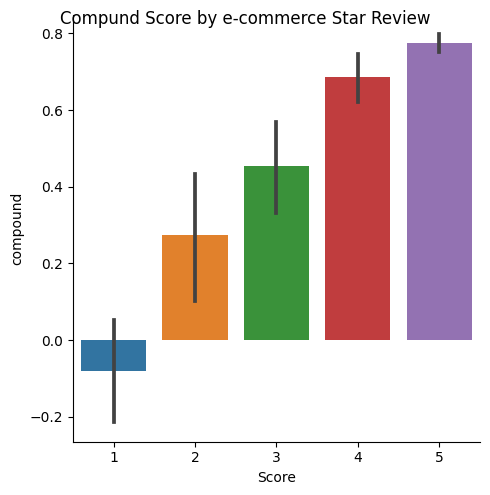

In [15]:
# plot mean compond score in each review score
g = sns.catplot(data=vaders, x='Score', y='compound', kind='bar')
g.fig.suptitle('Compund Score by e-commerce Star Review')
plt.show()

This is what we expect. Higher star reviews have more postive words in the reviews resulting in larger compound socres.

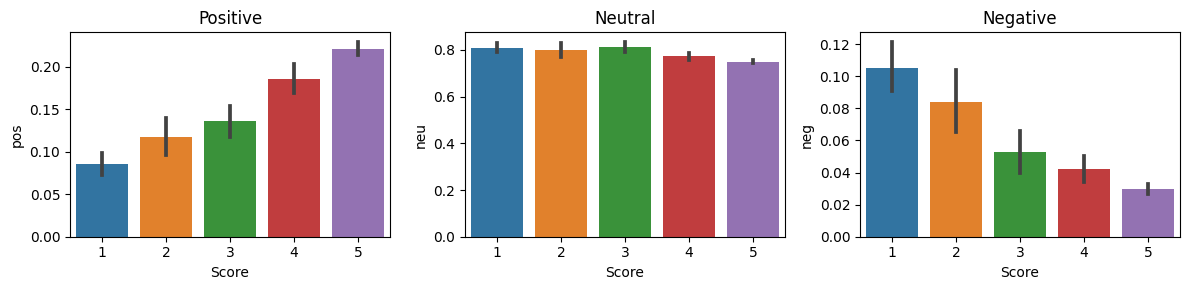

In [16]:
# visualize pos/neu/neg socres in each star score
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Looking at positive and negative scores, these scores are an inverse relationship.

# Method 2: RoBERTa Pretrained Model

A robustly optimised BERT pre-trained approach (RoBERTa) for NLP classification tasks. It is based on Google's BERT model released in 2018.

Transformer model consider the words as well as the context a the sentence which is not considered in the VADER.  

Read more [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta)

In [19]:
# install packages
# ! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00


In [20]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

>Tokenization is the process of breaking sentences into a collection of words called ***token***




In [21]:
# build a RoBERTa model
model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

**Tokenizer**:  
return_tensors(str, optional):   
* `tf`: Return TensorFlow tf.constant objects.
* `pt`: Return PyTorch torch.Tensor objects  
* `np`: Return Numpy np.ndarray objects.

The output is a dictionary with three keys:
* `input_id`: List of token ids to be fed to a model  
* `token_type_id`: List of token type ids to be fed to a model  
* `attention_mask`: List of indices specifying which tokens should be attended to by the model

See details  in [Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer)

In [22]:
# Run for RoBERTa Model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

The max sequence length that RoBERTa can handle at once is **512** , (**`max_position_embeddings`** : int , optional, defaults to 512).

  <br>

* One simple way to handle longer sentences beyond 512 tokens is to split longer texts into smaller pieces. Automatic truncation is implementated in the original BERT and works well.


* The DeBERTa large model has a larger max sequence length (upto 24528 tokens) than RoBERTa or other BERT like architectures.

<br>

respository for [DeBERTa](https://github.com/microsoft/DeBERTa).

<br>

This dataset contains texts longer 512 tokens resulting in `RuntimeError`. In this example, try and except statements are used to avoid this error.



In [23]:
# Run the polarity score on the entire dataset

# store the result
res = {}

# store Id fails analysis
broken_id = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']

        # VANDER sentiment score
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        # rename vander_score key
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        # Roberta sentiment score
        roberta_result = polarity_scores_roberta(text)
        both = vader_result_rename | roberta_result
        res[myid] = both

    except RuntimeError:
        print(f'Broke for id {myid}')
        broken_id.append(myid)

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [57]:
len(str(df[df['Id']==i]['Text'].values))

2508

In [66]:
# quickly examine text length
broken_id
for i in broken_id:
  text_length = len(df[df['Id']==i]['Text'].values[0].split())
  print(f'Removed text Id: {i}, word counts: {text_length}')

Removed text Id: 83, word counts: 430
Removed text Id: 187, word counts: 405
Removed text Id: 529, word counts: 540
Removed text Id: 540, word counts: 866
Removed text Id: 746, word counts: 405
Removed text Id: 863, word counts: 434


In [25]:
df_results = pd.DataFrame(res).T
df_results = df_results.reset_index().rename(columns={'index': 'Id'})
df_results = df_results.merge(df, how='left')

# Compare VANDER sentiment score and RoBERTa sentiment score

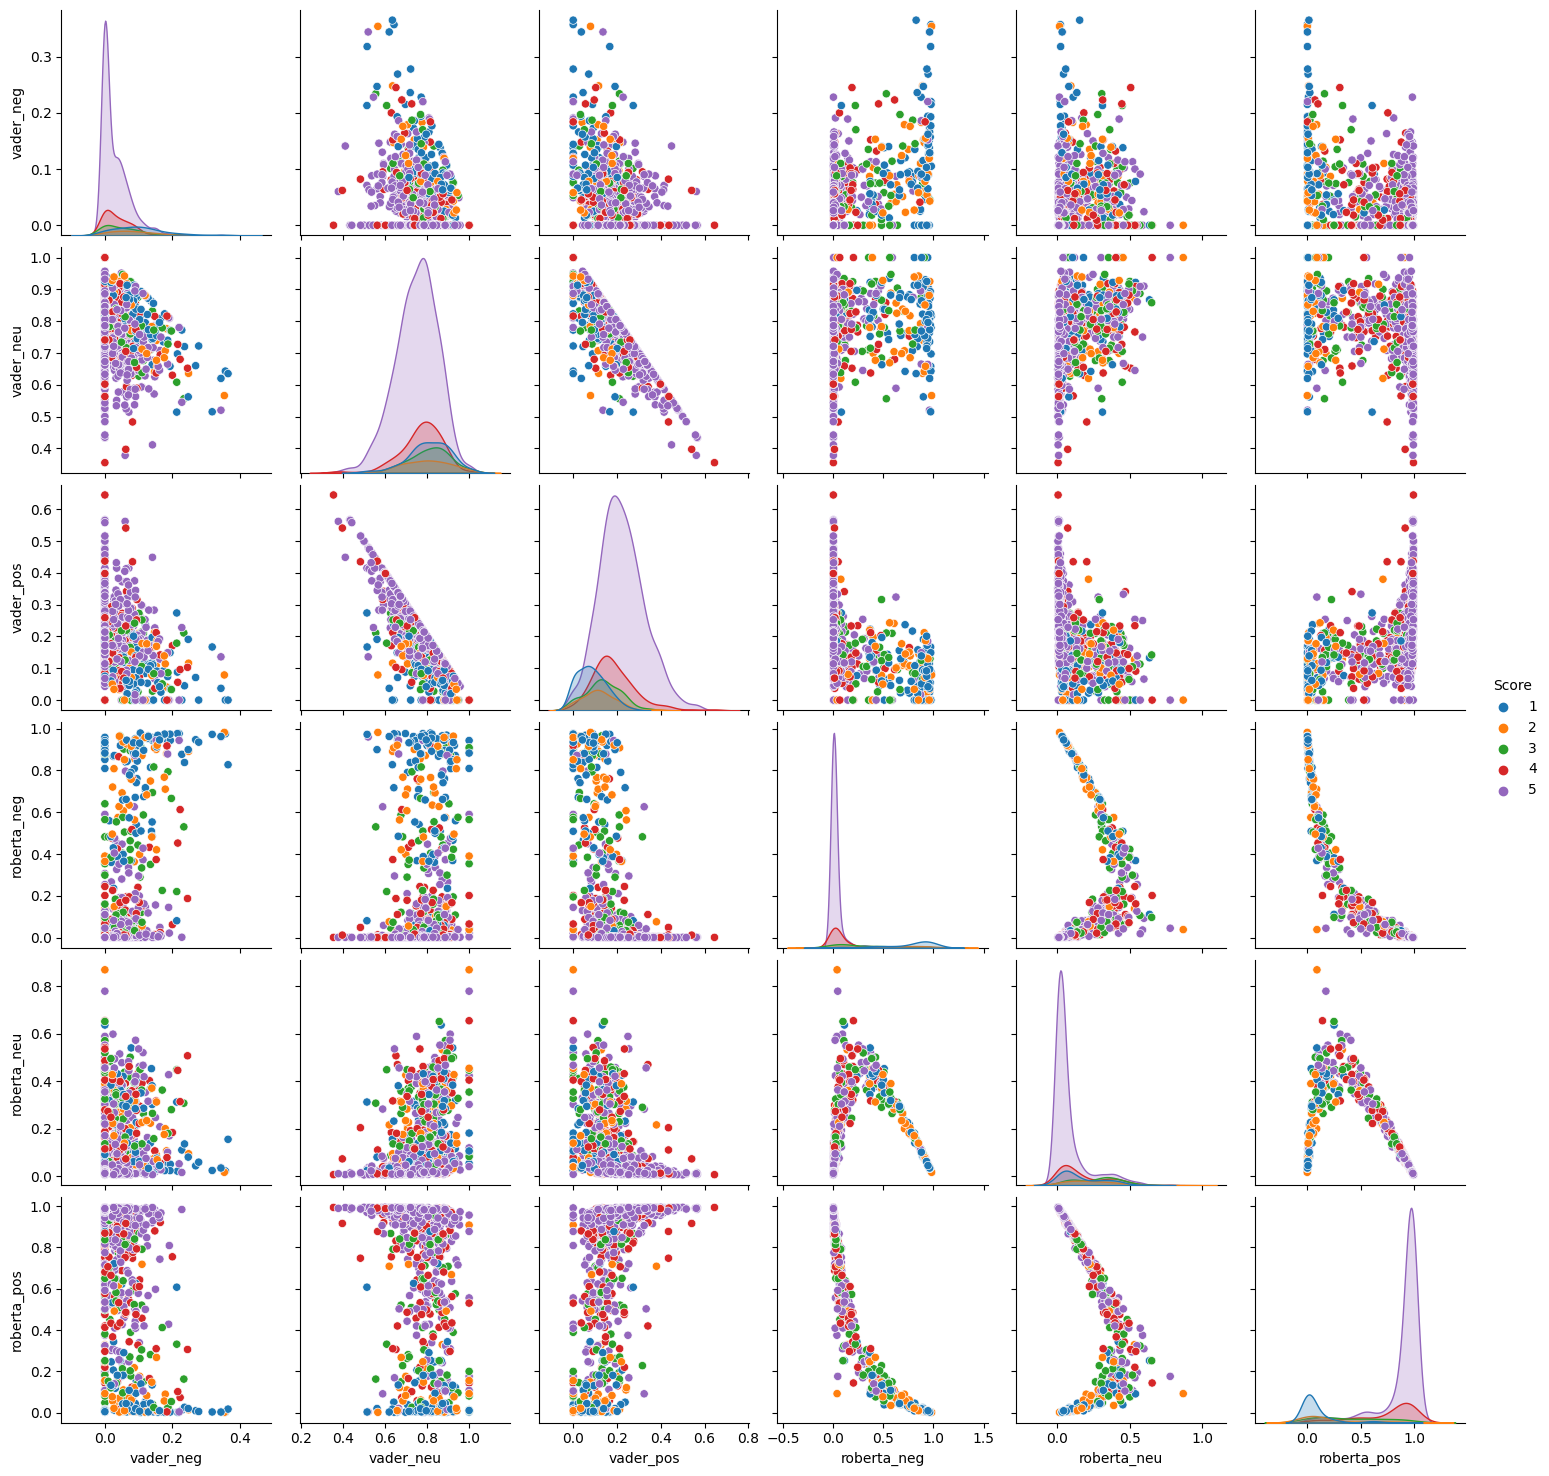

In [26]:
# pair plot to visualize correlation between two approaches
sns.pairplot(data=df_results,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

### Examine sentiment scores

In [27]:
df_results[df_results.Score ==1].sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [28]:
df_results[df_results.Score ==1].sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [29]:
df_results[df_results.Score ==5].sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [30]:
df_results[df_results.Score ==5].sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'